In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# GRAPH 1: Categories des jeux-vidéos

Firstly, we would like to display the distribution of `Gaming` videos in the Youniverse dataset. We need the **category of all videos** to do so (~73 millions). Since the raw data takes a lot of space because of text descriptions (around **100 Go**), we prefer to use the `.feather` file format to load the data.

In [3]:
videos_metadata_df = pd.read_feather("../data/youniverse/original/yt_metadata_helper.feather", columns=['categories'])

videos_metadata_df

,categories
0,Film & Animation
1,Film & Animation
2,Film & Animation
3,Film & Animation
4,Film & Animation
...,...
72924789,News & Politics
72924790,News & Politics
72924791,News & Politics
72924792,News & Politics


The first step is obtaining the proportion of **each category** in the dataset.

In [4]:
true_category_percentages_df = videos_metadata_df['categories'].value_counts(normalize=True).mul(100).round(2).to_frame()

true_category_percentages_df.head(8)

,proportion
categories,
Gaming,18.81
Entertainment,16.83
News & Politics,12.18
Music,11.39
People & Blogs,9.48
Sports,5.97
Howto & Style,5.44
Education,5.20


`Gaming` is the most popular category, with close to **20%** of videos. It is great for our further analysis to have such a large amount of data, since it will allow us to have a more accurate representation of the gaming community on YouTube.

Now, we just want to do a slight post-processing and group every category that has less than **3%** of the total videos into a new category called `Other`, to have a more readable graph.

In [5]:
# Combine into a new dataframe
pie_values_df = pd.DataFrame(true_category_percentages_df[true_category_percentages_df >= 3])

# Put every other category into 'Other'
less_than_3 = true_category_percentages_df[true_category_percentages_df < 3]
sum_less_than_3 = less_than_3.sum()
pie_values_df.loc['Other'] = sum_less_than_3

# Rename columns and drop NaN values
pie_values_df = pie_values_df.rename(columns={'proportion': 'value'}).dropna()

pie_values_df

,value
categories,
Gaming,18.81
Entertainment,16.83
News & Politics,12.18
Music,11.39
People & Blogs,9.48
Sports,5.97
Howto & Style,5.44
Education,5.20
Science & Technology,3.30


As a sanity check, we ensure that the sum of the proportions of the categories is equal to **100%**.

In [6]:
assert pie_values_df['value'].sum() == 100

Looks more readable, right? Now we can move on to the **plotting** part!

In [7]:
categories = pie_values_df.index.tolist()
values = pie_values_df['value'].tolist()

# Generating colors for the pie
colors = sns.color_palette('hls', n_colors=len(categories))

# Create the final pie chart data
pie_chart_data_df = pd.DataFrame({
    'id': categories,
    'label': categories,
    'value': values,
    'color': colors
})

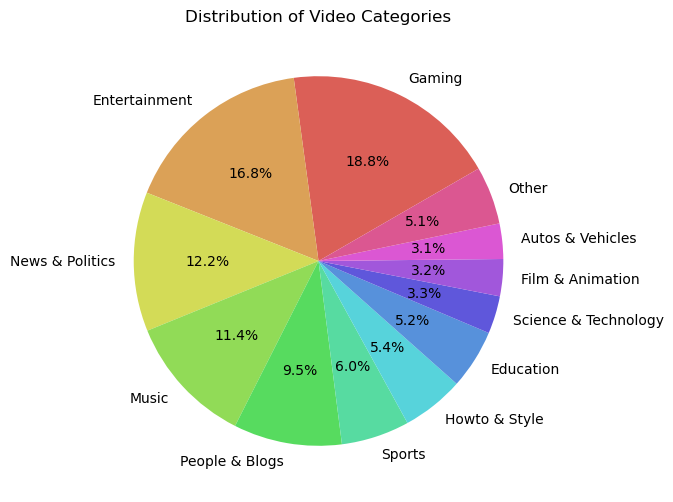

In [8]:
# Plot the pie chart
plt.figure(figsize=(6, 6))

plt.pie(
    pie_chart_data_df['value'],
    labels=pie_chart_data_df['label'],
    colors=pie_chart_data_df['color'],
    autopct='%1.1f%%',
    startangle=30
)

plt.title("Distribution of Video Categories")
plt.show()

The last step is exporting to a `.json` so we use this data in our **Datastory website**.

In [10]:
pie_chart_data_df.to_json('../datastory/data/category_percentages.json', orient='records')

# GRAPH 10: Markov Chain Transition Matrix Heatmap

Our next step is to generate a **Markov Chain Transition Matrix** heatmap. It will be builded from the weights 

In [13]:
# Load weights data
weights_df = pd.read_csv("../data/youniverse/filtered/games_edges_all.csv")

weights_df.head(2)

,game1,game2,weight
0,fortnite,minecraft,8238018
1,minecraft,roblox,7883337


In [20]:
gaming_videos_with_games_df = pl.read_parquet("../data/youniverse/filtered/gaming_videos_with_games.parquet")

gaming_videos_with_games_df.head(2)

title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id,video_game
str,str,str,f64,f64,f64,i64,str,str,str
"""lego city lego police1 hour lo…","""lego city lego police lego cit…","""2016-09-26 00:00:00""",1253.0,9.0,0.0,3442,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""y5IvyZlzELs""","""lego city undercover"""
"""lego city police lego fireman …","""lego city lego police lego cit…","""2016-09-25 00:00:00""",2311.0,8.0,0.0,2407,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""m1agc0qT0BY""","""lego city undercover"""


In [ ]:
games_count = gaming_videos_with_games_df.group_by('video_game').agg(pl.count('video_game').alias('count')).sort('count', descending=True)
top20games_df = games_count.head(20).to_pandas()

top20games_df

,video_game,count
0,minecraft,766154
1,fortnite,377337
2,call of duty,368658
3,league of legends,236065
4,roblox,205762
5,grand theft auto,205011
6,dota 2,149407
7,super smash bros,92470
8,final fantasy,80449
9,the sims,77628


In [11]:
filtered_weights_df = weights_df[weights_df['game1'].isin(top20games_df['video_game']) & weights_df['game2'].isin(top20games_df['video_game'])]

# Add reverse edges (i.e., swap game1 and game2)
reverse_edges_df = filtered_weights_df.rename(columns={'game1': 'game2', 'game2': 'game1'})
reverse_edges_df['weight'] = filtered_weights_df['weight']  # Ensure the weight remains the same

# Concatenate the reverse edges with the original filtered edges
filtered_weights_df = pd.concat([filtered_weights_df, reverse_edges_df], ignore_index=True)

# Add each game with itself and a weight of 0 using pd.concat
additional_rows = pd.DataFrame({'game1': top20games_df['video_game'], 'game2': top20games_df['video_game'], 'weight': 0})

# Concatenate the new rows with the filtered DataFrame
filtered_weights_df = pd.concat([filtered_weights_df, additional_rows], ignore_index=True)

# Merge popularity data for game1 and game2
filtered_weights_df = filtered_weights_df.merge(top20games_df[['video_game', 'count']], left_on='game1', right_on='video_game', how='left').rename(columns={'count': 'popularity_game1'})
filtered_weights_df = filtered_weights_df.merge(top20games_df[['video_game', 'count']], left_on='game2', right_on='video_game', how='left').rename(columns={'count': 'popularity_game2'})

# Sort by the popularity of game1 and game2
filtered_weights_df = filtered_weights_df.sort_values(by=['popularity_game1', 'popularity_game2'], ascending=[False, False]).reset_index(drop=True)
drop_columns = ['video_game_x', 'popularity_game1', 'video_game_y', 'popularity_game2']
filtered_weights_df = filtered_weights_df.drop(columns=drop_columns)

filtered_weights_df


,game1,game2,weight
0,minecraft,minecraft,0
1,minecraft,fortnite,8238018
2,minecraft,call of duty,5680816
3,minecraft,league of legends,1503122
4,minecraft,roblox,7883337
...,...,...,...
395,destiny 2,dark souls,194212
396,destiny 2,plants vs zombies,49022
397,destiny 2,street fighter,73831
398,destiny 2,fallout 4,207051


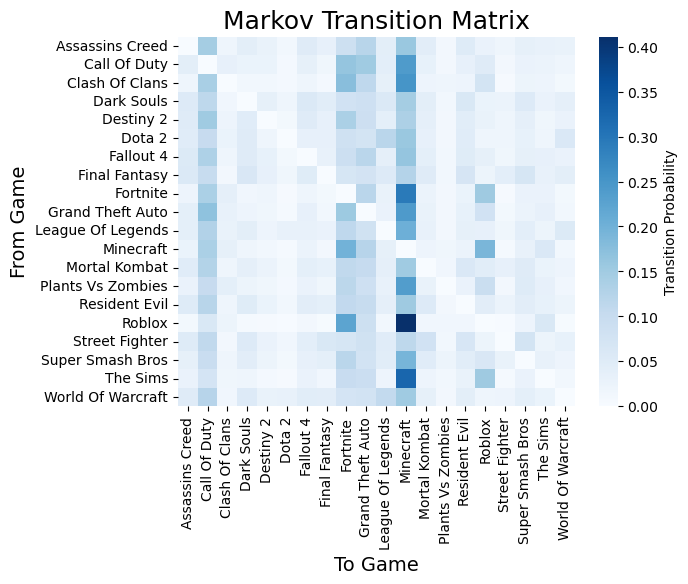

In [43]:
filtered_weights_df['game1'] = filtered_weights_df['game1'].str.title()
filtered_weights_df['game2'] = filtered_weights_df['game2'].str.title()
row_sums = filtered_weights_df.groupby('game1')['weight'].sum()

filtered_weights_df['probability'] = filtered_weights_df.apply(lambda row: row['weight'] / row_sums[row['game1']], axis=1)

markov_matrix = filtered_weights_df.pivot_table(index='game1', columns='game2', values='probability', fill_value=0)

sns.heatmap(markov_matrix, cmap='Blues', annot=False, fmt=".2f", cbar_kws={'label': 'Transition Probability'});

plt.xlabel('To Game', fontsize=14)
plt.ylabel('From Game', fontsize=14)
plt.title('Markov Transition Matrix', fontsize=18);

In [44]:
# Sanity check

row_sums = markov_matrix.sum(axis=1)
assert (row_sums - 1).abs().max() < 1e-9

In [ ]:
import json

# Convert the Markov matrix to a dictionary of lists, where keys are game1 and values are lists of game2 -> probability
markov_dict = markov_matrix.to_dict(orient='index')

# Prepare the final structure in the required format
markov_json = [
    {"id": game1, "data": [{"x": game2, "y": prob} for game2, prob in game_probs.items()]}
    for game1, game_probs in markov_dict.items()
]

# Convert to JSON formatted string
json_output = json.dumps(markov_json, indent=2)

# Optionally, save it to a file
with open('../datastory/data/markov_matrix.json', 'w') as f:
    f.write(json_output)

# Stats 5: Pourcentage des channels qui ont le jeu comme jeu principal / channels qui ont au moins une vid dessus

In [49]:
gaming_videos_with_games_df

title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id,video_game
str,str,str,f64,f64,f64,i64,str,str,str
"""lego city lego police1 hour lo…","""lego city lego police lego cit…","""2016-09-26 00:00:00""",1253.0,9.0,0.0,3442,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""y5IvyZlzELs""","""lego city undercover"""
"""lego city police lego fireman …","""lego city lego police lego cit…","""2016-09-25 00:00:00""",2311.0,8.0,0.0,2407,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""m1agc0qT0BY""","""lego city undercover"""
"""lego city police lego fireman …","""lego city lego city police leg…","""2016-09-21 00:00:00""",792.0,8.0,0.0,1209,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""ZGll5_wD9Ys""","""lego city undercover"""
"""lego jurassic world complete m…","""lego jurassic world lego city …","""2016-09-21 00:00:00""",1.141393e6,2076.0,426.0,2053,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""kYkokQgnu20""","""lego jurassic world"""
"""lego marvel superheroes comple…","""lego marvel lego marvel super …","""2016-09-21 00:00:00""",1648.0,9.0,1.0,4125,"""UCzWrhkg9eK5I8Bm3HfV-unA""","""9EuAW3zjWuc""","""spiderman"""
…,…,…,…,…,…,…,…,…,…
"""carrying an irl friend in rank…","""brawlhalla cosolix ranked coso…","""2018-09-26 00:00:00""",10397.0,368.0,12.0,558,"""UCrwIEEqUWswVQ_L_VzfeR-Q""","""s6mBrPKvumc""","""brawlhalla"""
"""playing 2s with planet micro""","""brawlhalla cosolix ranked coso…","""2018-09-25 00:00:00""",13954.0,574.0,16.0,363,"""UCrwIEEqUWswVQ_L_VzfeR-Q""","""qneHrPX4_AY""","""brawlhalla"""
"""brawlhalla how to play against…","""brawlhalla cosolix ranked coso…","""2018-09-24 00:00:00""",24198.0,596.0,32.0,713,"""UCrwIEEqUWswVQ_L_VzfeR-Q""","""4H4Oz0Rjd70""","""brawlhalla"""


In [ ]:
game_counts_per_channel = (
    gaming_videos_with_games_df.group_by(['channel_id', 'video_game'])
    .agg(pl.count())
    .rename({'count': 'video_count'})
)

game_counts_per_channel = game_counts_per_channel.sort('video_count', descending=True)
game_counts_per_channel

channel_id,video_game,video_count
str,str,u32
"""UChkYqBSmrYsPjOTK2N4pdWg""","""league of legends""",38217
"""UCHORW8bOKFCeS_ipezw4uKA""","""dota 2""",10296
"""UCN9WmtfPT0BA_I3pHq_HcbA""","""angry birds""",9789
"""UCQJT7rpynlR7SSdn3OyuI_Q""","""league of legends""",9278
"""UC1MiVrMfNrs5Ma4BetX-asA""","""dota 2""",9006
…,…,…
"""UCPYJR2EIu0_MJaDeSGwkIVw""","""soulcalibur""",1
"""UCzcwNjySc1sdL67FRLezIBQ""","""metal gear""",1
"""UCcMKSZLvheCzTQ3lTQsWooQ""","""metal gear""",1


In [120]:
target_games = ["minecraft", "fortnite", "call of duty"]

main_game_per_channel = (
    game_counts_per_channel
    .sort(["channel_id", "video_count"], descending=[False, True])
    .group_by("channel_id")
    .agg(
        pl.first("video_game").alias("main_game"),
        pl.first("video_count").alias("main_game_count")
    )
)

channels_with_game = (
    game_counts_per_channel
    .filter(pl.col("video_game").is_in(target_games))
    .group_by("video_game")
    .agg(
        pl.n_unique("channel_id").alias("channels_with_at_least_one_vid")
    )
)

main_game_counts = (
    main_game_per_channel
    .filter(pl.col("main_game").is_in(target_games))
    .group_by("main_game")
    .agg(
        pl.n_unique("channel_id").alias("channels_with_main_game")
    )
)

result = (
    channels_with_game
    .join(main_game_counts, left_on="video_game", right_on="main_game", how="left")
    .with_columns(
        (pl.col("channels_with_main_game").fill_null(0) / pl.col("channels_with_at_least_one_vid") * 100).round(2)
        .alias("percentage")
    )
)

result

video_game,channels_with_at_least_one_vid,channels_with_main_game,percentage
str,u32,u32,f64
"""fortnite""",9448,3587,37.97
"""minecraft""",8358,2737,32.75
"""call of duty""",7239,1828,25.25


In [ ]:
new_df = (
    gaming_videos_with_games_df
    .group_by('video_game')
    .agg(pl.count('video_game').alias('count'))
    .sort('count', descending=True)
)

# Calculate the percentage column
new_df = new_df.with_columns(
    (pl.col('count') / pl.col('count').sum() * 100).round(2).alias('percentage')
)

new_df.head(10)

video_game,count,percentage
str,u32,f64
"""minecraft""",766154,11.23
"""fortnite""",377337,5.53
"""call of duty""",368658,5.4
"""league of legends""",236065,3.46
"""roblox""",205762,3.02
"""grand theft auto""",205011,3.01
"""dota 2""",149407,2.19
"""super smash bros""",92470,1.36
"""final fantasy""",80449,1.18
